# Cosine Similarity Analysis of Model Predictions During Denoising

This notebook analyzes the cosine similarity between model predictions and ground truth velocities during the denoising process. We'll:

1. Load a trained model from a checkpoint
2. Perform denoising for a single example and track velocities
3. Calculate cosine similarities between model predictions and ground truth velocities
4. Visualize the results
5. Extend the analysis to multiple examples and compute statistics
6. Visualize top-k tokens for each denoising step with probabilities and L2 distances

In [21]:
import os
import sys
from pathlib import Path

import lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from datasets import Dataset

# Add parent directory to path to import shortcutfm modules
sys.path.append('..')

from shortcutfm.batch import collate
from shortcutfm.config import TrainingConfig
from shortcutfm.text_datasets import TextDataset
from shortcutfm.train.pl.trainer_factory import (
    create_criterion,
    load_unit_from_checkpoint,
)

## Load Configuration and Model

First, we'll load the training configuration from a checkpoint directory and initialize the model.

In [22]:
# Set the checkpoint directory
checkpoint_dir = Path("../checkpoints/run_q2qzjeso")
checkpoint_path = checkpoint_dir / "epoch=190-step=27100.ckpt"
training_config_path = checkpoint_dir / "training_config.yaml"

# Load training configuration
with open(training_config_path) as f:
    yaml_cfg = OmegaConf.load(f)

training_config = TrainingConfig(**OmegaConf.to_container(yaml_cfg, resolve=True))
print(f"Loaded training config from {training_config_path}")

Loaded training config from ..\checkpoints\run_q2qzjeso\training_config.yaml


In [23]:

print(f"Checkpoint exists: {os.path.exists(checkpoint_path)}")
print(f"Checkpoint permissions: {oct(os.stat(checkpoint_path).st_mode)[-3:]}")

Checkpoint exists: True
Checkpoint permissions: 666


In [24]:
# Set random seed for reproducibility
pl.seed_everything(training_config.seed)

# Create criterion and load model from checkpoint
criterion = create_criterion(training_config)
unit = load_unit_from_checkpoint(criterion, checkpoint_path, training_config)
print(f"Loaded model from {checkpoint_path}")

# Set the model to evaluation mode
unit.eval()

Seed set to 44


shortcut embedding: Sequential(
  (0): Linear(in_features=128, out_features=512, bias=True)
  (1): SiLU()
  (2): Linear(in_features=512, out_features=768, bias=True)
)
word emebedding reuires grad: False
lm head requires grad: True
Using MSE loss
Using MSE loss
Loaded model from ..\checkpoints\run_q2qzjeso\epoch=190-step=27100.ckpt


TrainModule(
  (criterion): CompositeCriterion(
    (model): FlowMatchingModel(
      (module): TransformerNetModel(
        (word_embedding): Embedding(30522, 768)
        (lm_head): Linear(in_features=768, out_features=30522, bias=True)
        (time_embed): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=768, bias=True)
        )
        (input_up_proj): Identity()
        (backbone_transformer): BertEncoderBackbone(
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0-11): 12 x BertLayer(
                (attention): BertAttention(
                  (self): BertSdpaSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_features=768, out_features=768, bias=True)
                    (value): Linear(in_features=768, out_features=768, bias=True)
                    (dropout

## Load Test Data

Now we'll load some test data to use for our analysis.

In [25]:
# Load test dataset
test_data_path = "../datasets/tokenized/bert-base-uncased/QQP-Official/test"
test_ds = Dataset.load_from_disk(test_data_path)
test_text_ds = TextDataset(test_ds)

# Create a small batch for analysis
batch_size = 8
test_dataloader = DataLoader(
    test_text_ds,
    batch_size=batch_size,
    collate_fn=collate,
    shuffle=False,
)

# Get a single batch for analysis
test_batch = next(iter(test_dataloader))
print(f"Loaded test batch with {len(test_batch.seqs)} examples")

Loaded test batch with 8 examples


## Implement Denoising with Velocity Tracking

We'll implement a custom denoising function that tracks model predictions and ground truth velocities at each step.

In [47]:
def denoise_with_tracking(model, batch, shortcut_size, per_token_cosine=True, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Perform denoising while tracking model predictions and ground truth velocities.
    
    Args:
        model: The model to use for denoising
        batch: The batch to denoise
        shortcut_size: The shortcut size to use for denoising
        per_token_cosine: If True, calculate cosine similarity for each token separately and take the mean.
                          If False, flatten all tokens into a single vector before calculating similarity.
        device: The device to use for computation
        
    Returns:
        A dictionary containing:
        - predicted_velocities: Model's predicted velocities at each step
        - ground_truth_velocities: Ground truth velocities at each step
        - timesteps: Timesteps used during denoising
        - cosine_similarities: Cosine similarities between predicted and ground truth velocities
    """
    model.eval()
    diffusion_steps = model.criterion.model.diffusion_steps

    # Move individual tensors in batch to device instead of the whole batch
    seqs = batch.seqs.to(device)
    input_ids_mask = batch.input_ids_mask.to(device)
    padding_mask = batch.padding_mask.to(device)

    # Initialize tracking variables
    predicted_velocities = []
    ground_truth_velocities = []
    timesteps_list = []
    cosine_similarities = []

    with torch.no_grad():
        # Get input mask and embeddings
        input_mask = input_ids_mask.unsqueeze(-1)
        embeddings = model.criterion.model.get_embeddings(seqs)

        # Initialize with noise where mask is 0
        noise = torch.randn_like(embeddings)
        x_t = torch.where(input_mask == 0, embeddings, noise)

        # Store the original embeddings as ground truth x0
        x0_ground_truth = embeddings.clone()

        # Denoising loop
        shortcuts = torch.tensor(shortcut_size, device=device).repeat(input_mask.shape[0])

        for t in torch.arange(diffusion_steps, 0, -shortcut_size, device=device):
            t_batch = t.repeat(input_mask.shape[0])
            timesteps_list.append(t.item())

            # Get model prediction
            model_output = model.criterion.model(x_t, t_batch, shortcuts)

            # Restore input part based on mask
            model_output = torch.where(input_mask == 0, x_t, model_output)

            # Calculate predicted velocity (v_hat)
            v_hat = model_output - x_t
            v_hat = torch.where(input_mask == 0, torch.zeros_like(v_hat), v_hat)

            # Calculate ground truth velocity
            v_ground_truth = x0_ground_truth - x_t
            v_ground_truth = torch.where(input_mask == 0, torch.zeros_like(v_ground_truth), v_ground_truth)

            # Store velocities
            predicted_velocities.append(v_hat.clone())
            ground_truth_velocities.append(v_ground_truth.clone())

            # Calculate cosine similarity between predicted and ground truth velocities
            cos_sim = calculate_batch_cosine_similarity(v_hat, v_ground_truth, input_mask, padding_mask.unsqueeze(-1), per_token=per_token_cosine)
            cosine_similarities.append(cos_sim)

            # Update x_t for next step
            x0_hat = x_t + (shortcuts / diffusion_steps)[:, None, None] * v_hat
            x_t = x0_hat

    return {
        "predicted_velocities": predicted_velocities,
        "ground_truth_velocities": ground_truth_velocities,
        "timesteps": timesteps_list,
        "cosine_similarities": cosine_similarities
    }

In [48]:
def calculate_batch_cosine_similarity(pred_velocities, gt_velocities, input_mask, padding_mask, per_token=True):
    """
    Calculate cosine similarity between predicted and ground truth velocities for a batch.
    Only considers positions that are both non-input (input_mask=1) and non-padding (padding_mask=1).
    
    Args:
        pred_velocities: Predicted velocities [batch_size, seq_len, hidden_dim]
        gt_velocities: Ground truth velocities [batch_size, seq_len, hidden_dim]
        input_mask: Mask indicating input positions (1 for non-input) [batch_size, seq_len, 1]
        padding_mask: Mask indicating padding (0 for padding, 1 for actual tokens) [batch_size, seq_len, 1]
        per_token: If True, calculate cosine similarity for each token separately and take the mean.
                   If False (default), flatten all tokens into a single vector before calculating similarity.
        
    Returns:
        Tensor of cosine similarities for each example in the batch [batch_size]
    """
    batch_size = pred_velocities.shape[0]
    cos_sims = []

    for i in range(batch_size):
        # Get masks for this example and combine them
        example_input_mask = input_mask[i].bool().squeeze(-1)  # [seq_len]
        example_padding_mask = padding_mask[i].bool().squeeze(-1)  # [seq_len]

        # Combined mask: positions that are both non-input AND non-padding
        combined_mask = example_input_mask & example_padding_mask

        # Get velocities for valid positions (non-input and non-padding)
        pred_vel = pred_velocities[i][combined_mask]  # [num_valid, hidden_dim]
        gt_vel = gt_velocities[i][combined_mask]  # [num_valid, hidden_dim]

        # print(f"pred_vel: {pred_vel.shape}, gt_vel: {gt_vel.shape}")

        if pred_vel.shape[0] == 0:  # No non-input positions
            print(f"No non-input positions for example {i}")
            cos_sims.append(torch.tensor(1.0, device=pred_velocities.device))
            continue

        if per_token:
            # Calculate cosine similarity for each token separately
            if pred_vel.shape[0] > 0:
                # Calculate cosine similarity for each token [num_valid]
                token_cos_sims = torch.nn.functional.cosine_similarity(pred_vel, gt_vel)
                # Take mean across tokens
                cos_sim = token_cos_sims.mean()
            else:
                print(f"pred_vel has no valid positions for example {i}")
                cos_sim = torch.tensor(1.0, device=pred_velocities.device)
        else:
            # Flatten to treat all non-input positions as a single vector
            pred_vel_flat = pred_vel.reshape(-1)  # [num_non_input * hidden_dim]
            gt_vel_flat = gt_vel.reshape(-1)  # [num_non_input * hidden_dim]

            # Calculate cosine similarity for the flattened vector
            cos_sim = torch.nn.functional.cosine_similarity(pred_vel_flat.unsqueeze(0), gt_vel_flat.unsqueeze(0))

        cos_sims.append(cos_sim)

    return torch.stack(cos_sims)

In [49]:
def denoise_with_token_tracking(model, batch, shortcut_size, top_k=5, example_idx=0, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Perform denoising while tracking model predictions and token probabilities for visualization.
    
    Args:
        model: The model to use for denoising
        batch: The batch to denoise
        shortcut_size: The shortcut size to use for denoising
        top_k: Number of top tokens to track at each step
        example_idx: Index of the example in the batch to track
        device: The device to use for computation
        
    Returns:
        A dictionary containing:
        - timesteps: Timesteps used during denoising
        - token_probs: Top-k token probabilities at each step for each position
        - token_ids: Top-k token IDs at each step for each position
        - token_texts: Decoded tokens at each step for each position
        - l2_distances: L2 distances between predicted embeddings and token embeddings
        - loss_positions: Positions that contribute to the loss (non-input, non-padding)
    """
    # Get model parameters
    diffusion_steps = model.criterion.model.diffusion_steps
    # Access tokenizer through flow_matching_criterion in composite criterion
    tokenizer = model.criterion.flow_matching_criterion.tokenizer

    # Move individual tensors in batch to device
    seqs = batch.seqs.to(device)
    input_ids_mask = batch.input_ids_mask.to(device)
    padding_mask = batch.padding_mask.to(device)

    # Select a single example to track
    seq = seqs[example_idx:example_idx+1]
    input_mask = input_ids_mask[example_idx:example_idx+1].unsqueeze(-1)
    pad_mask = padding_mask[example_idx:example_idx+1].unsqueeze(-1)

    # Get embeddings
    embeddings = model.criterion.model.get_embeddings(seq)

    # Calculate loss mask (positions that contribute to loss)
    loss_mask = (input_mask.bool() & pad_mask.bool()).squeeze(-1).squeeze(0)
    loss_positions = loss_mask.nonzero().squeeze(-1).cpu().numpy()

    # Initialize tracking variables
    timesteps_list = []
    token_probs_list = []
    token_ids_list = []
    token_texts_list = []
    l2_distances_list = []

    # Denoising loop
    shortcuts = torch.tensor(shortcut_size, device=device).repeat(input_mask.shape[0])

    # Get word embedding matrix for L2 distance calculation
    word_embeddings = model.criterion.model.module.word_embedding.weight

    with torch.no_grad():
        # Start with random noise for non-input positions
        noise = torch.randn_like(embeddings)
        x_t = torch.where(input_mask == 0, embeddings, noise)

        # Denoising steps
        for t in range(diffusion_steps, 0, -1):
            # Convert to tensor and move to device
            timesteps = torch.full((input_mask.shape[0],), t, device=device, dtype=torch.long)

            # Get model prediction (velocity)
            v_hat = model.criterion.model(x_t, timesteps, shortcuts)

            # Calculate logits and probabilities
            logits = model.criterion.model.compute_logits(x_t)
            probs = torch.softmax(logits, dim=-1)

            # Get top-k tokens and their probabilities for positions that contribute to loss
            top_probs, top_indices = [], []
            l2_distances = []

            for pos in loss_positions:
                # Get top-k tokens and probabilities for this position
                pos_probs, pos_indices = torch.topk(probs[0, pos], k=top_k)
                top_probs.append(pos_probs.cpu().numpy())
                top_indices.append(pos_indices.cpu().numpy())

                # Calculate L2 distances between current embedding and token embeddings
                current_emb = x_t[0, pos].unsqueeze(0)  # [1, hidden_dim]
                token_embs = word_embeddings[pos_indices]  # [top_k, hidden_dim]
                l2_dist = torch.norm(current_emb - token_embs, dim=1).cpu().numpy()
                l2_distances.append(l2_dist)

            # Store results for this timestep
            timesteps_list.append(t)
            token_probs_list.append(top_probs)
            token_ids_list.append(top_indices)
            token_texts_list.append([[tokenizer.decode([idx]) for idx in pos_indices] for pos_indices in top_indices])
            l2_distances_list.append(l2_distances)

            # Update x_t for next step (simple Euler step)
            x_t = x_t - (1.0 / diffusion_steps) * v_hat

    return {
        "timesteps": timesteps_list,
        "token_probs": token_probs_list,
        "token_ids": token_ids_list,
        "token_texts": token_texts_list,
        "l2_distances": l2_distances_list,
        "loss_positions": loss_positions
    }

def visualize_top_k_tokens(token_results, timestep_indices=None, figsize=(15, 20)):
    """
    Visualize top-k tokens for selected timesteps.
    
    Args:
        token_results: Results from denoise_with_token_tracking
        timestep_indices: Indices of timesteps to visualize (default: first, middle, last)
        figsize: Figure size for the plots
    """
    timesteps = token_results["timesteps"]
    token_probs = token_results["token_probs"]
    token_texts = token_results["token_texts"]
    l2_distances = token_results["l2_distances"]
    loss_positions = token_results["loss_positions"]

    # Select timesteps to visualize if not provided
    if timestep_indices is None:
        num_steps = len(timesteps)
        timestep_indices = [0, num_steps // 2, num_steps - 1]  # First, middle, last

    # Create figure with two rows (probabilities and L2 distances) for each timestep
    fig, axes = plt.subplots(len(timestep_indices), 2, figsize=figsize)

    # If only one timestep, make axes 2D
    if len(timestep_indices) == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(timestep_indices):
        t = timesteps[idx]
        probs = token_probs[idx]
        texts = token_texts[idx]
        l2_dists = l2_distances[idx]

        # Plot token probabilities
        ax_prob = axes[i, 0]

        # Prepare data for stacked bar chart
        num_positions = len(loss_positions)
        num_tokens = len(probs[0])  # Number of tokens per position (top-k)

        # Create x positions for bars
        x = np.arange(num_positions)
        width = 0.8

        # Plot stacked bars for each position
        bottom = np.zeros(num_positions)
        for j in range(num_tokens):
            # Extract probabilities for the j-th token at each position
            token_j_probs = [pos_probs[j] for pos_probs in probs]

            # Get token texts for labels
            token_j_texts = [pos_texts[j] for pos_texts in texts]

            # Plot bar
            bars = ax_prob.bar(x, token_j_probs, width, bottom=bottom, label=f'Token {j+1}')

            # Add token text labels to bars
            for k, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0.05:  # Only add label if bar is tall enough
                    ax_prob.text(bar.get_x() + bar.get_width()/2, bottom[k] + height/2,
                             token_j_texts[k], ha='center', va='center', rotation=90,
                             fontsize=8, color='white', fontweight='bold')

            # Update bottom for next stack
            bottom += token_j_probs

        # Set title and labels
        ax_prob.set_title(f'Top-{num_tokens} Token Probabilities at Timestep {t}')
        ax_prob.set_xlabel('Token Position')
        ax_prob.set_ylabel('Probability')
        ax_prob.set_xticks(x)
        ax_prob.set_xticklabels([f'Pos {pos}' for pos in loss_positions])
        ax_prob.set_ylim(0, 1)
        ax_prob.grid(axis='y', linestyle='--', alpha=0.7)

        # Plot L2 distances
        ax_l2 = axes[i, 1]

        # Plot stacked bars for each position
        bottom = np.zeros(num_positions)
        for j in range(num_tokens):
            # Extract L2 distances for the j-th token at each position
            token_j_l2 = [pos_l2[j] for pos_l2 in l2_dists]

            # Get token texts for labels
            token_j_texts = [pos_texts[j] for pos_texts in texts]

            # Plot bar
            bars = ax_l2.bar(x, token_j_l2, width, label=f'Token {j+1}')

            # Add token text labels to bars
            for k, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0.5:  # Only add label if bar is tall enough
                    ax_l2.text(bar.get_x() + bar.get_width()/2, height/2,
                            token_j_texts[k], ha='center', va='center', rotation=90,
                            fontsize=8, color='black', fontweight='bold')

        # Set title and labels
        ax_l2.set_title(f'L2 Distances at Timestep {t}')
        ax_l2.set_xlabel('Token Position')
        ax_l2.set_ylabel('L2 Distance')
        ax_l2.set_xticks(x)
        ax_l2.set_xticklabels([f'Pos {pos}' for pos in loss_positions])
        ax_l2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

## Single Example Analysis

Let's analyze the denoising process for a single example.

In [50]:
# Set shortcut size for denoising
shortcut_size = 1024

# Run denoising with tracking
results = denoise_with_tracking(unit, test_batch, shortcut_size, per_token_cosine=True)

# Extract results
timesteps = results["timesteps"]
cosine_similarities = [cs.cpu().numpy() for cs in results["cosine_similarities"]]

# Convert to numpy for easier plotting
cosine_similarities_np = np.array([cs.mean().item() for cs in cosine_similarities])

print(f"Analyzed denoising process with {len(timesteps)} steps")
cosine_similarities
# results

Analyzed denoising process with 2 steps


[array([0.9992312 , 0.9994736 , 0.9993938 , 0.9995402 , 0.9995824 ,
        0.9994706 , 0.99968684, 0.99954784, 0.9997711 , 0.99995667,
        0.99944913, 0.99932826, 0.9995559 , 0.9993621 , 0.99953777,
        0.9993844 ], dtype=float32),
 array([0.99768925, 0.9976286 , 0.99739784, 0.9981548 , 0.9983266 ,
        0.99851614, 0.9987227 , 0.9982912 , 0.99910116, 0.999856  ,
        0.9975849 , 0.9971636 , 0.99828   , 0.9974523 , 0.9981303 ,
        0.9975509 ], dtype=float32)]

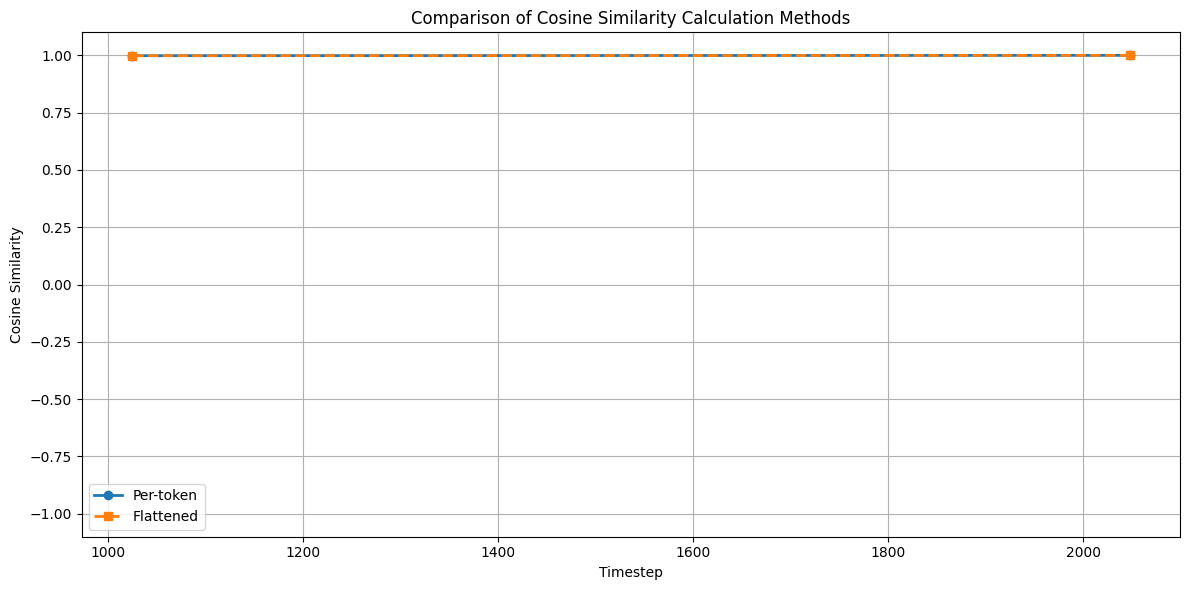

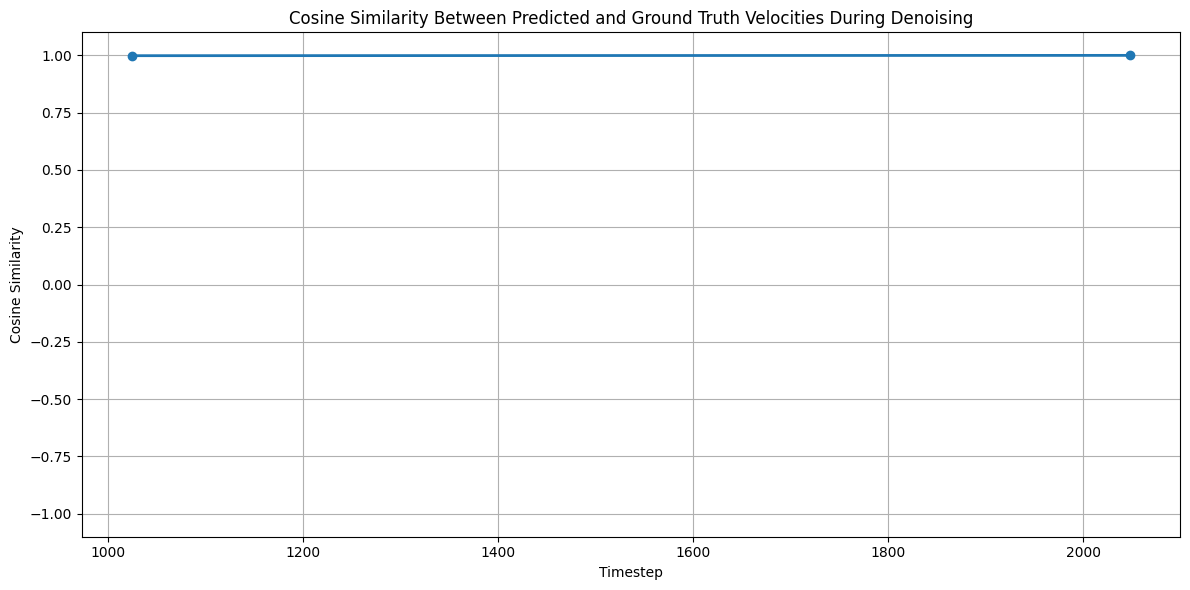


Visualizing top-k tokens for each denoising step...


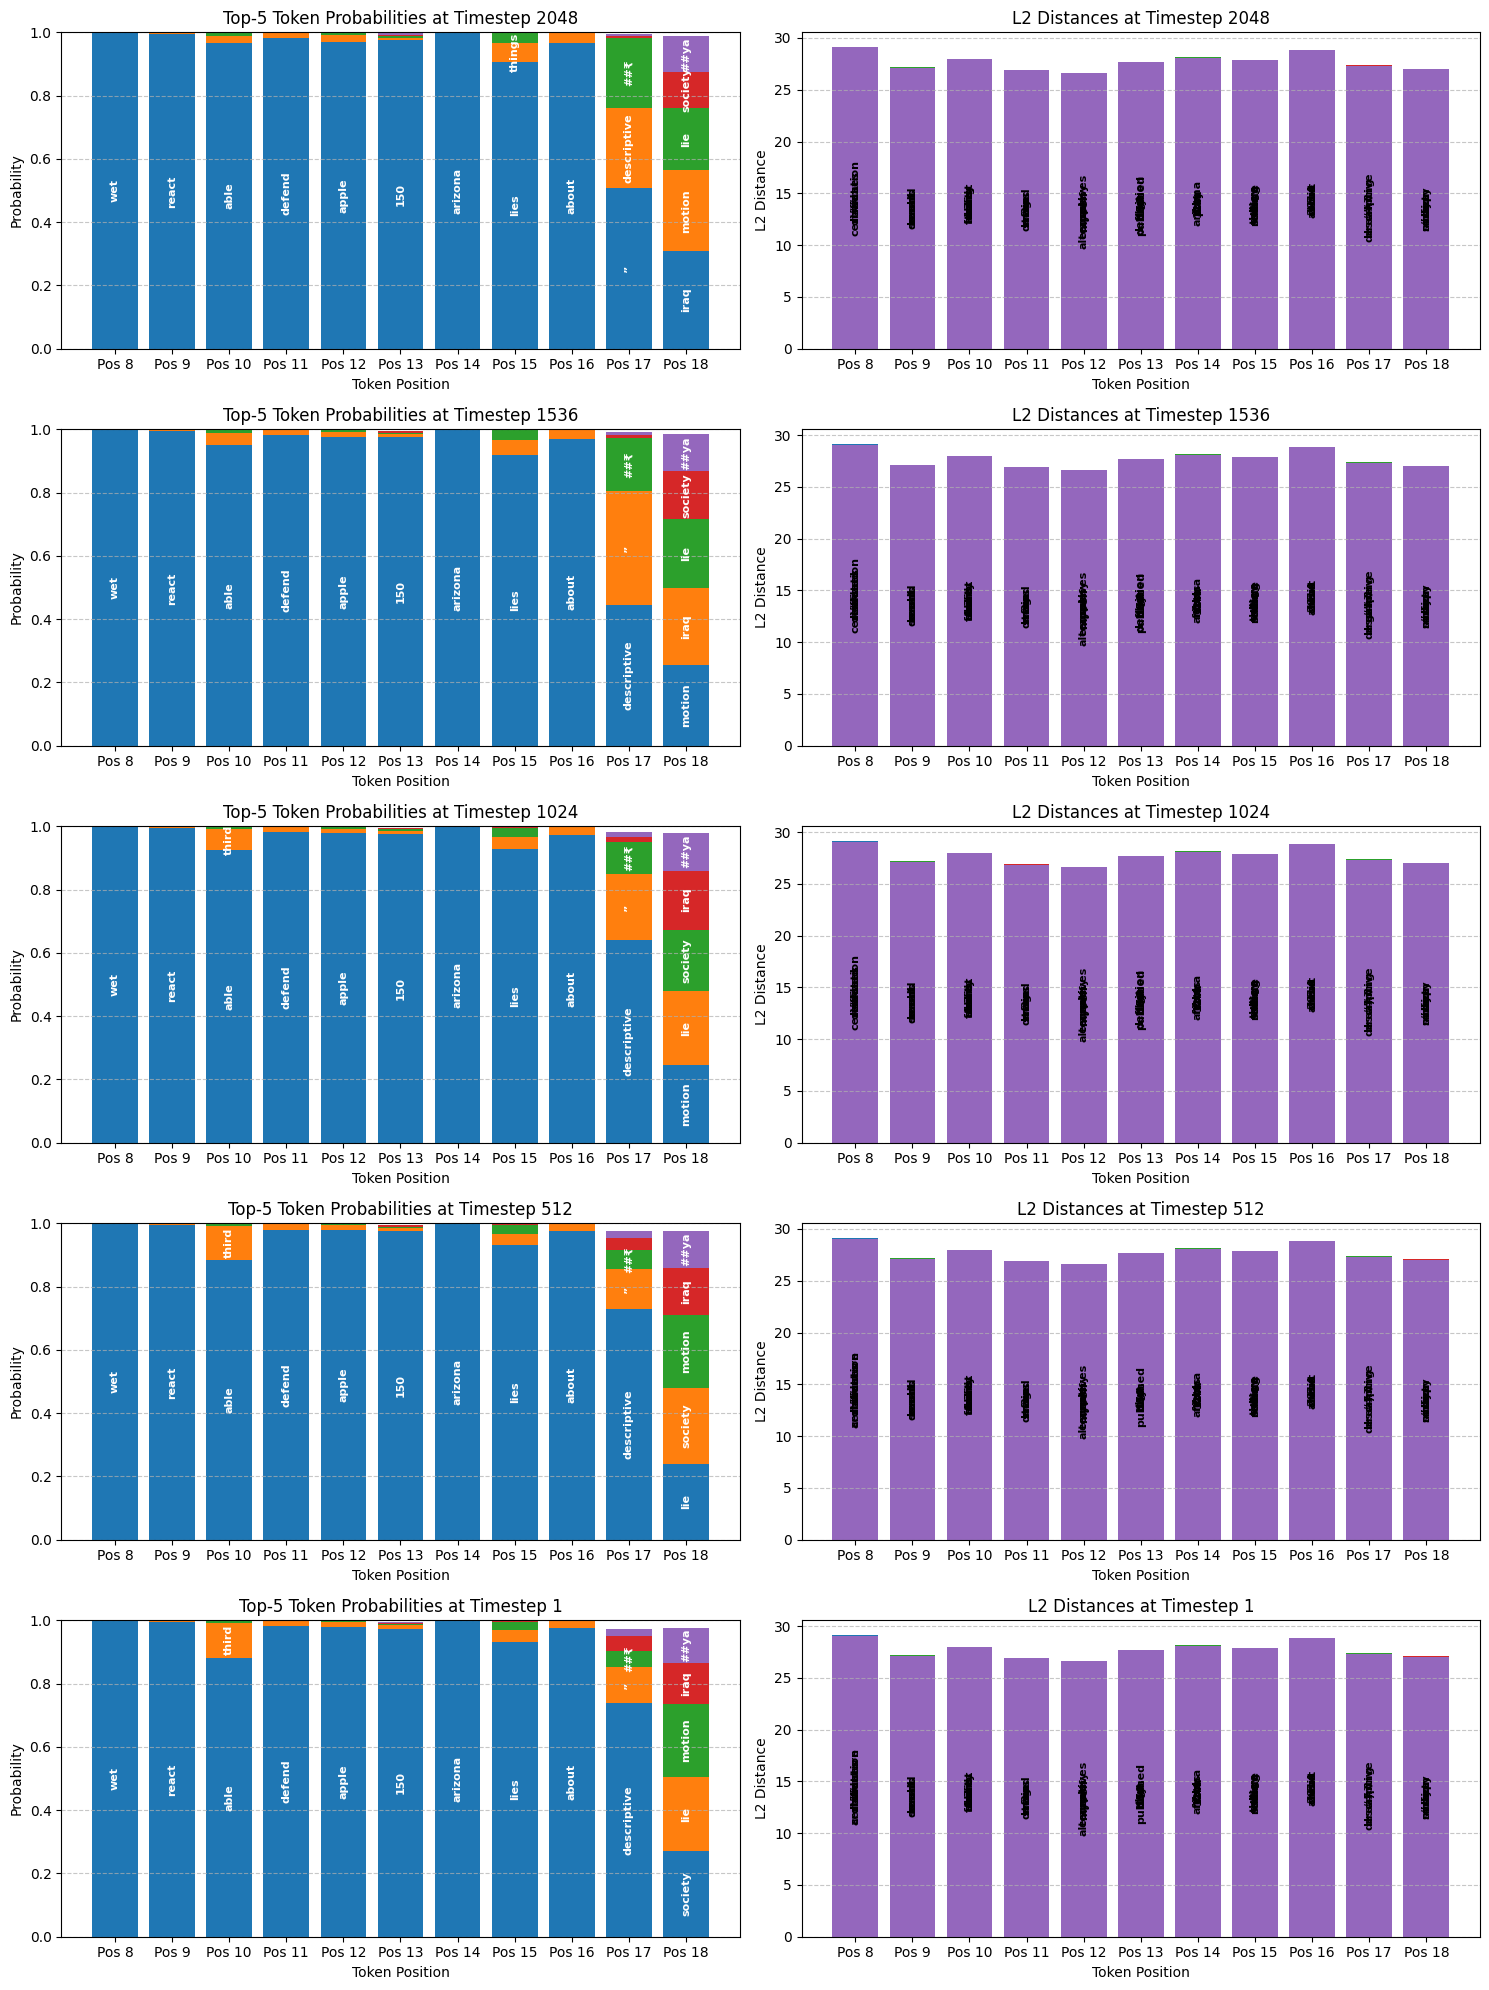

In [52]:
# Compare per-token vs flattened cosine similarity calculations
results_per_token = denoise_with_tracking(unit, test_batch, shortcut_size, per_token_cosine=True)
results_flattened = denoise_with_tracking(unit, test_batch, shortcut_size, per_token_cosine=False)

# Extract results
timesteps = results_per_token["timesteps"]
cosine_similarities_per_token = [cs.cpu().numpy().mean() for cs in results_per_token["cosine_similarities"]]
cosine_similarities_flattened = [cs.cpu().numpy().mean() for cs in results_flattened["cosine_similarities"]]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(timesteps, cosine_similarities_per_token, marker='o', linestyle='-', linewidth=2, label='Per-token')
plt.plot(timesteps, cosine_similarities_flattened, marker='s', linestyle='--', linewidth=2, label='Flattened')
plt.title('Comparison of Cosine Similarity Calculation Methods')
plt.xlabel('Timestep')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.ylim(-1.1, 1.1)  # Cosine similarity range
plt.legend()
plt.tight_layout()
plt.show()

# Plot original cosine similarities over timesteps
plt.figure(figsize=(12, 6))
plt.plot(timesteps, cosine_similarities_np, marker='o', linestyle='-', linewidth=2)
plt.title('Cosine Similarity Between Predicted and Ground Truth Velocities During Denoising')
plt.xlabel('Timestep')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.ylim(-1.1, 1.1)  # Cosine similarity range
plt.tight_layout()
plt.show()

# Visualize top-k tokens for each denoising step
print("\nVisualizing top-k tokens for each denoising step...")
token_results = denoise_with_token_tracking(unit, test_batch, shortcut_size, top_k=5)

# Select a few representative timesteps to visualize
timesteps = token_results["timesteps"]
num_steps = len(timesteps)

# Choose timesteps at different points in the denoising process
timestep_indices = [0, num_steps // 4, num_steps // 2, 3 * num_steps // 4, num_steps - 1]

# Visualize the selected timesteps
visualize_top_k_tokens(token_results, timestep_indices=timestep_indices)

## Individual Example Analysis

Let's look at the cosine similarities for each example in the batch.

ValueError: x and y must have same first dimension, but have shapes (2048,) and (2,)

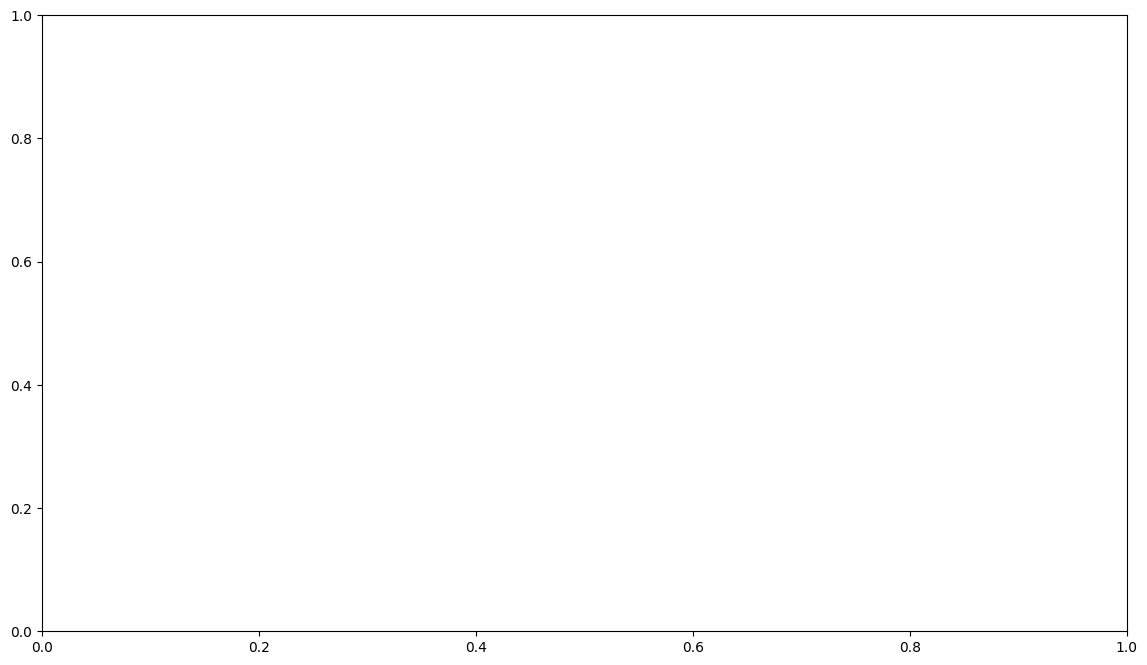

In [54]:
# Plot cosine similarities for each example
plt.figure(figsize=(14, 8))

for i in range(len(test_batch.seqs)):
    example_cos_sims = [cs[i].item() for cs in results["cosine_similarities"]]
    plt.plot(timesteps, example_cos_sims, marker='.', linestyle='-', label=f'Example {i+1}')

plt.title('Cosine Similarity by Example During Denoising')
plt.xlabel('Timestep')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.ylim(-1.1, 1.1)  # Cosine similarity range
plt.legend()
plt.tight_layout()
plt.show()

## Batch Analysis

Now let's analyze multiple batches to get more robust statistics.

In [55]:
def analyze_multiple_batches(model, dataloader, shortcut_size, num_batches=5):
    """
    Analyze cosine similarities across multiple batches.
    
    Args:
        model: The model to use for denoising
        dataloader: DataLoader providing batches
        shortcut_size: Shortcut size for denoising
        num_batches: Number of batches to analyze
        
    Returns:
        Dictionary with aggregated statistics
    """
    all_cosine_sims = []
    timesteps = None

    # Process multiple batches
    dataloader_iter = iter(dataloader)
    for i in tqdm(range(num_batches), desc="Processing batches"):
        try:
            batch = next(dataloader_iter)
        except StopIteration:
            break

        # Run denoising with tracking
        results = denoise_with_tracking(model, batch, shortcut_size, per_token_cosine=True)

        # Store timesteps from first batch
        if timesteps is None:
            timesteps = results["timesteps"]

        # Extract and store cosine similarities
        batch_cos_sims = [cs.cpu().numpy() for cs in results["cosine_similarities"]]
        all_cosine_sims.append(batch_cos_sims)

    # Aggregate results
    num_steps = len(timesteps)
    aggregated_cos_sims = []

    for step in range(num_steps):
        step_sims = []
        for batch_idx in range(len(all_cosine_sims)):
            step_sims.extend(all_cosine_sims[batch_idx][step])
        aggregated_cos_sims.append(np.array(step_sims))

    # Calculate statistics for each timestep
    mean_cos_sims = np.array([sims.mean() for sims in aggregated_cos_sims])
    std_cos_sims = np.array([sims.std() for sims in aggregated_cos_sims])
    min_cos_sims = np.array([sims.min() for sims in aggregated_cos_sims])
    max_cos_sims = np.array([sims.max() for sims in aggregated_cos_sims])

    return {
        "timesteps": timesteps,
        "mean": mean_cos_sims,
        "std": std_cos_sims,
        "min": min_cos_sims,
        "max": max_cos_sims,
        "all_data": aggregated_cos_sims
    }

In [56]:
# Create a larger test dataloader for batch analysis
batch_size = 16
test_dataloader = DataLoader(
    test_text_ds,
    batch_size=batch_size,
    collate_fn=collate,
    shuffle=False,
)

# Analyze multiple batches
batch_results = analyze_multiple_batches(unit, test_dataloader, shortcut_size, num_batches=5)

Processing batches:   0%|          | 0/5 [00:00<?, ?it/s]

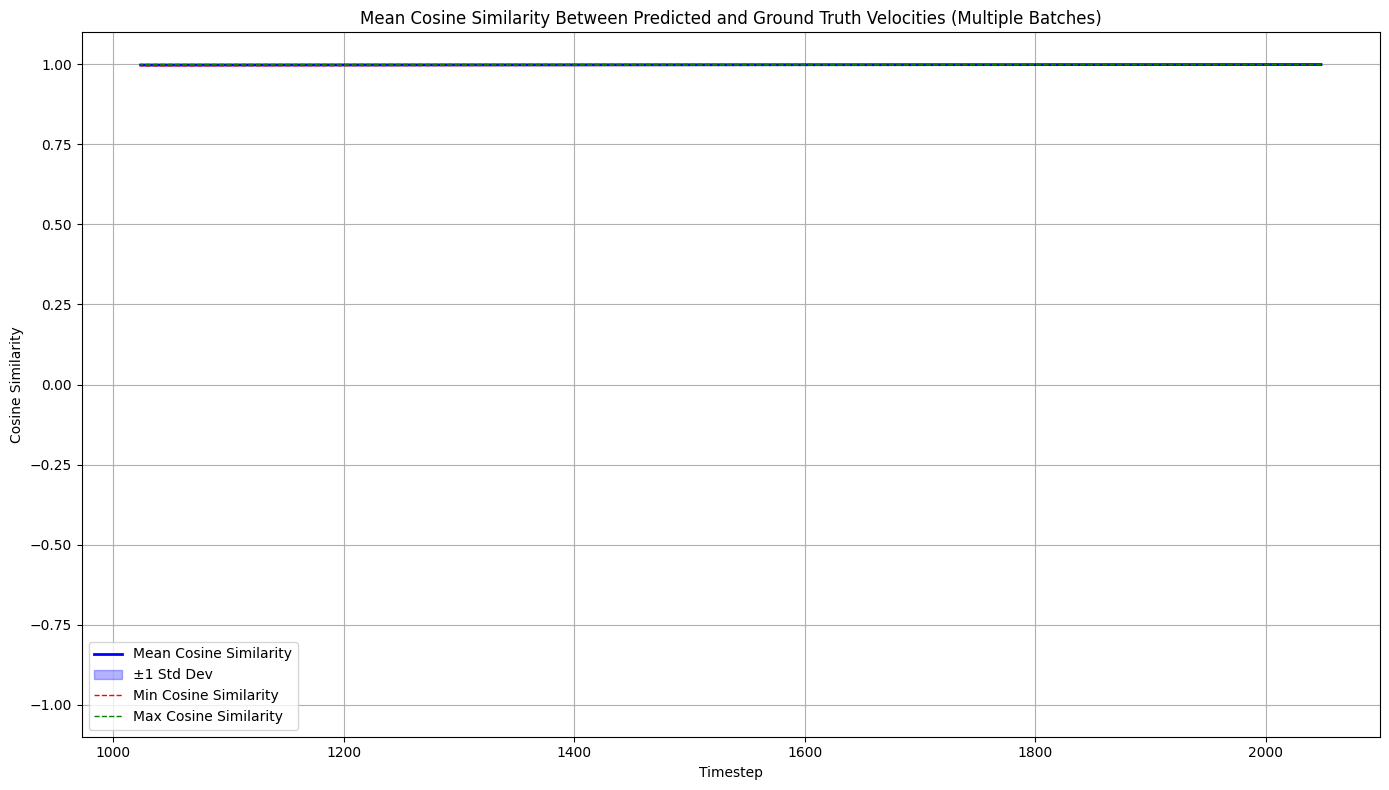

In [57]:
# Plot mean cosine similarity with error bands
plt.figure(figsize=(14, 8))

timesteps = batch_results["timesteps"]
mean_cos_sims = batch_results["mean"]
std_cos_sims = batch_results["std"]

plt.plot(timesteps, mean_cos_sims, 'b-', linewidth=2, label='Mean Cosine Similarity')
plt.fill_between(timesteps,
                 mean_cos_sims - std_cos_sims,
                 mean_cos_sims + std_cos_sims,
                 alpha=0.3,
                 color='b',
                 label='±1 Std Dev')

plt.plot(timesteps, batch_results["min"], 'r--', linewidth=1, label='Min Cosine Similarity')
plt.plot(timesteps, batch_results["max"], 'g--', linewidth=1, label='Max Cosine Similarity')

plt.title('Mean Cosine Similarity Between Predicted and Ground Truth Velocities (Multiple Batches)')
plt.xlabel('Timestep')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.ylim(-1.1, 1.1)  # Cosine similarity range
plt.legend()
plt.tight_layout()
plt.show()

## Distribution of Cosine Similarities

Let's visualize the distribution of cosine similarities at different timesteps.

In [58]:
timesteps

[2048, 1024]

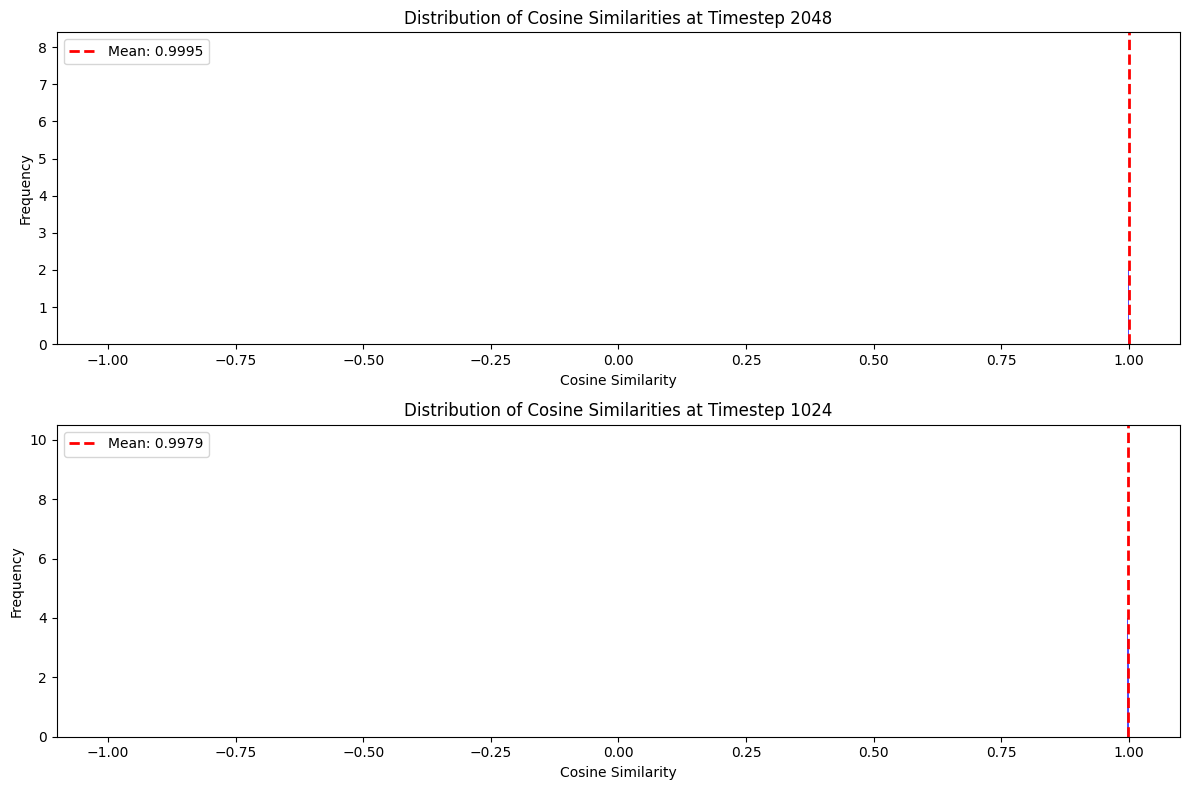

In [59]:
# Select a few representative timesteps to visualize
timesteps = batch_results["timesteps"]
num_steps = len(timesteps)

# Choose timesteps at different points in the denoising process
# Ensure we get unique timesteps by checking the actual timestep values
indices_to_plot = []
timesteps_to_plot = []

# Add first timestep
indices_to_plot.append(0)
timesteps_to_plot.append(timesteps[0])

# Add a few timesteps in between
potential_indices = [num_steps // 4, num_steps // 2, 3 * num_steps // 4]
for idx in potential_indices:
    ts = timesteps[idx]
    if ts not in timesteps_to_plot:  # Only add if this timestep isn't already in our list
        indices_to_plot.append(idx)
        timesteps_to_plot.append(ts)

# Add last timestep if it's different from what we already have
if timesteps[-1] not in timesteps_to_plot:
    indices_to_plot.append(num_steps - 1)
    timesteps_to_plot.append(timesteps[-1])

# Create histogram plots
if len(indices_to_plot) > 0:  # Only create plots if we have timesteps to plot
    fig, axes = plt.subplots(len(indices_to_plot), 1, figsize=(12, 4 * len(indices_to_plot)))

    # Handle the case where we only have one unique timestep
    if len(indices_to_plot) == 1:
        axes = [axes]  # Make axes a list with one element

    for i, (idx, ts) in enumerate(zip(indices_to_plot, timesteps_to_plot, strict=False)):
        ax = axes[i]
        cos_sims = batch_results["all_data"][idx]

        ax.hist(cos_sims, bins=30, alpha=0.7, color='blue')
        ax.axvline(x=cos_sims.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {cos_sims.mean():.4f}')

        ax.set_title(f'Distribution of Cosine Similarities at Timestep {ts}')
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Frequency')
        ax.set_xlim(-1.1, 1.1)
        ax.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No unique timesteps found to plot.")

## Conclusion

In this notebook, we've analyzed the cosine similarity between model predictions and ground truth velocities during the denoising process. This analysis provides insights into how well the model is learning to predict the correct direction of change at different timesteps.

Key observations:
1. The cosine similarity varies across different timesteps, indicating that the model's prediction accuracy changes during the denoising process.
2. There is variation in cosine similarity across different examples, suggesting that some examples are easier for the model to predict than others.
3. The distribution of cosine similarities at different timesteps provides insights into the model's behavior at different stages of denoising.

## Token Probability and L2 Distance Analysis

Let's analyze the top-k tokens for each denoising step, showing both probabilities and L2 distances.

In [46]:
# Load a test batch
test_batch = next(iter(test_dataloader))

# Set shortcut size for denoising
shortcut_size = 1024

# Run token tracking for a specific example
print("Running token tracking for a specific example...")
token_results = denoise_with_token_tracking(unit, test_batch, shortcut_size, top_k=5, example_idx=0)

# Get the original input sequence
input_ids = test_batch.seqs[0].cpu().numpy()
input_mask = test_batch.input_ids_mask[0].cpu().numpy()
padding_mask = test_batch.padding_mask[0].cpu().numpy()

# Print the input sequence
print("\nInput sequence (showing only non-padding tokens):")
tokens = []
for i, (token_id, is_padding) in enumerate(zip(input_ids, padding_mask, strict=False)):
    if is_padding:
        is_input = "Input" if input_mask[i] == 0 else "Target"
        token_text = unit.criterion.flow_matching_criterion.tokenizer.decode([token_id])
        tokens.append(f"{i}: {token_text} ({is_input})")

print("\n".join(tokens))

# Print the positions that contribute to the loss
print("\nPositions that contribute to the loss (non-input, non-padding):")
print(token_results["loss_positions"])

# Select specific timesteps to visualize
timesteps = token_results["timesteps"]
num_steps = len(timesteps)

# Choose timesteps at different points in the denoising process
if num_steps >= 5:
    timestep_indices = [0, num_steps // 4, num_steps // 2, 3 * num_steps // 4, num_steps - 1]
else:
    timestep_indices = list(range(num_steps))

# Visualize the selected timesteps
visualize_top_k_tokens(token_results, timestep_indices=timestep_indices, figsize=(15, 4 * len(timestep_indices)))

# Print the top tokens at the final timestep
print("\nTop tokens at the final timestep:")
final_timestep = token_results["timesteps"][-1]
final_token_texts = token_results["token_texts"][-1]
final_token_probs = token_results["token_probs"][-1]

for pos_idx, pos in enumerate(token_results["loss_positions"]):
    print(f"Position {pos}:")
    for token_idx, (token, prob) in enumerate(zip(final_token_texts[pos_idx], final_token_probs[pos_idx], strict=False)):
        print(f"  {token_idx+1}. {token} (prob: {prob:.4f})")
    print()

Running token tracking for a specific example...


AttributeError: 'CompositeCriterion' object has no attribute 'tokenizer'